In [ ]:
!pip install rarfile
!pip install gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import rarfile
import gdown
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Google Drive file ID (replace with your file ID)
file_id = '1ZHUhSUmwsvLBiIXuzS4p66RZcnvQbeAu'

# Output path where the file will be downloaded
output_path = '/content/Concealed_Pistol_Detection_Dataset.rar'

# Download the file from Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)

# Extract the RAR file
with rarfile.RarFile(output_path, 'r') as rf:
    rf.extractall('/content/data')

print("Extraction complete.")


Downloading...
From: https://drive.google.com/uc?id=1ZHUhSUmwsvLBiIXuzS4p66RZcnvQbeAu
To: /content/Concealed_Pistol_Detection_Dataset.rar
100%|██████████| 21.8M/21.8M [00:00<00:00, 28.5MB/s]


Extraction complete.


In [ ]:
# Step 2: Parse directory names to extract labels
data_with_labels = []
for root, dirs, files in os.walk('/content/data'):
    for dir_name in dirs:
        label = dir_name  # Assuming directory name is the label
        dir_path = os.path.join(root, dir_name)
        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            data_with_labels.append((file_path, label))

In [ ]:
print('Size of the dataset before augmentation is:',len(data_with_labels))

Size of the dataset before augmentation is: 358


In [ ]:
# Step 3: Define ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False, #vertical flipping is not recommended
    rescale=1./255,  # Normalization
    fill_mode='nearest'
)

In [ ]:
target_size = (224, 224)

augmented_data = []
for _ in range(3):  # Loop three times to create three times the data
    for data_sample, label in data_with_labels:
        # Load and preprocess the image
        img = load_img(data_sample)  # Load image
        img_array = img_to_array(img)  # Convert image to array

        # Rescale the image to [0, 1]
        img_array /= 255.0

        # Apply random transformation
        img_transformed = datagen.random_transform(img_array)

        # Resize transformed image to target size
        img_transformed = Image.fromarray((img_transformed * 255).astype('uint8')).resize(target_size)

        # Convert image back to array
        img_transformed = img_to_array(img_transformed)

        # Append transformed image and label to the list
        augmented_data.append((img_transformed, label))

In [ ]:
print('Size of the dataset after augmentation is:',len(augmented_data))

Size of the dataset after augmentation is: 1074


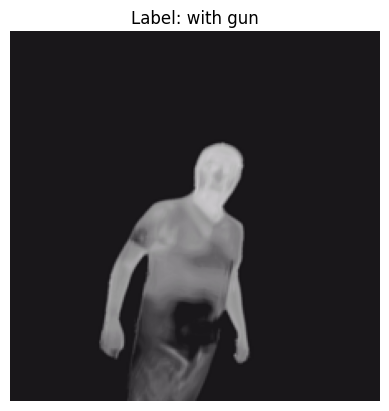

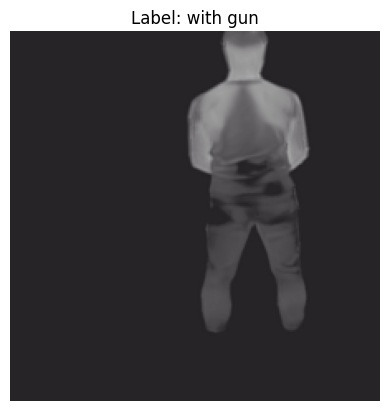

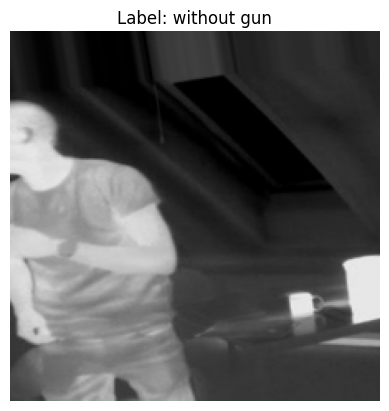

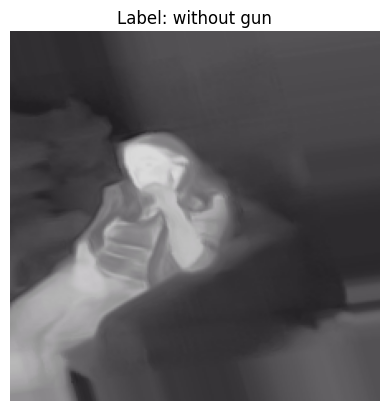

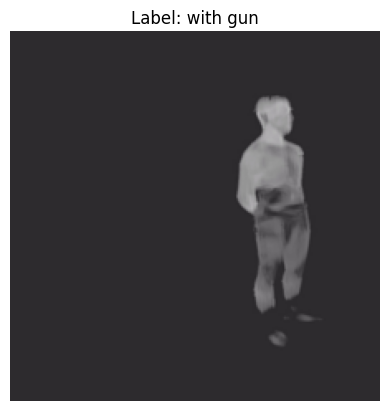

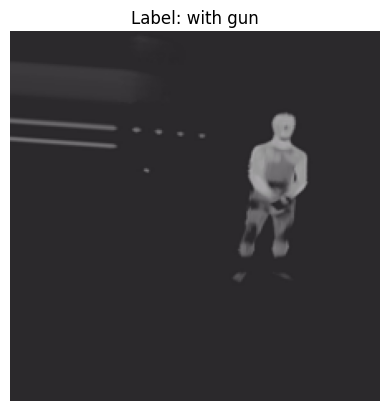

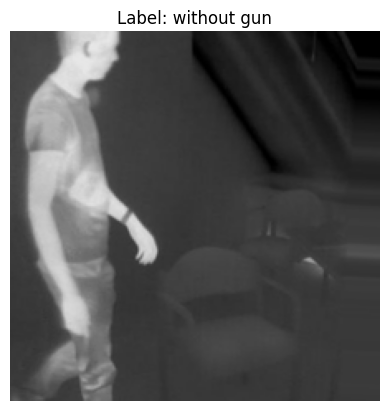

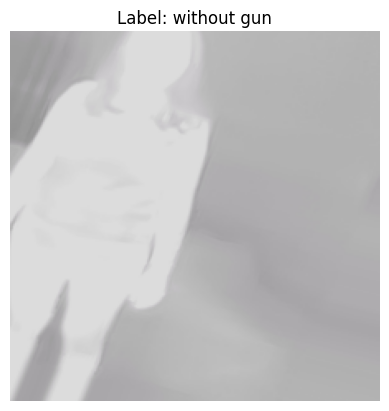

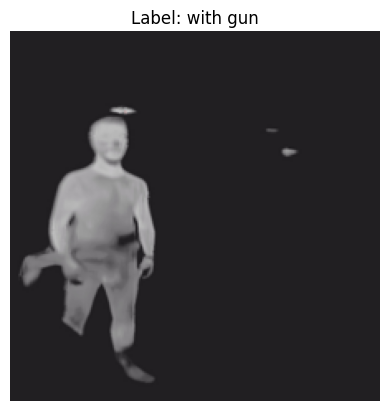

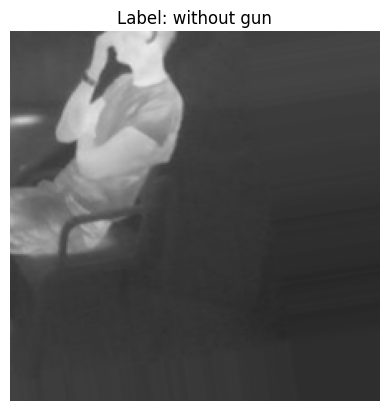

In [ ]:
for i in range(0,1000,100):
    img = augmented_data[i][0]

    # Clip the pixel values to the valid range for imshow
    img = np.clip(img, 0, 255).astype('uint8')

    plt.imshow(img)
    plt.title(f"Label: {augmented_data[i][1]}")
    plt.axis('off')
    plt.show()

In [ ]:
# Prepare data for VGG16
X = np.array([sample[0] for sample in augmented_data])
y = np.array([sample[1] for sample in augmented_data])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44, shuffle=True)

In [ ]:
label_encoder = LabelEncoder()

# Fit label encoder and transform labels
y_train = label_encoder.fit_transform(y_train)

In [ ]:
y_test = label_encoder.transform(y_test)

In [ ]:
# Load pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Freeze convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

In [ ]:
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Use binary_crossentropy for binary classification
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=7, validation_split=0.2)
history

Epoch 1/7
22/22 [==============================] - 22s 555ms/step - loss: 2.6038 - accuracy: 0.9316 - val_loss: 1.6022 - val_accuracy: 0.9535
Epoch 2/7
22/22 [==============================] - 3s 145ms/step - loss: 0.1655 - accuracy: 0.9913 - val_loss: 0.9599 - val_accuracy: 0.9709
Epoch 3/7
22/22 [==============================] - 4s 177ms/step - loss: 0.0153 - accuracy: 0.9985 - val_loss: 0.8533 - val_accuracy: 0.9826
Epoch 4/7
22/22 [==============================] - 3s 148ms/step - loss: 8.5830e-04 - accuracy: 1.0000 - val_loss: 0.9955 - val_accuracy: 0.9767
Epoch 5/7
22/22 [==============================] - 3s 146ms/step - loss: 5.3946e-09 - accuracy: 1.0000 - val_loss: 1.0138 - val_accuracy: 0.9767
Epoch 6/7
22/22 [==============================] - 3s 146ms/step - loss: 3.3363e-10 - accuracy: 1.0000 - val_loss: 1.0157 - val_accuracy: 0.9767
Epoch 7/7
22/22 [==============================] - 4s 178ms/step - loss: 2.6204e-10 - accuracy: 1.0000 - val_loss: 1.0159 - val_accuracy: 0.9

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

7/7 [==============================] - 6s 896ms/step - loss: 0.8778 - accuracy: 0.9721
Test Loss: 0.8778
Test Accuracy: 0.9721


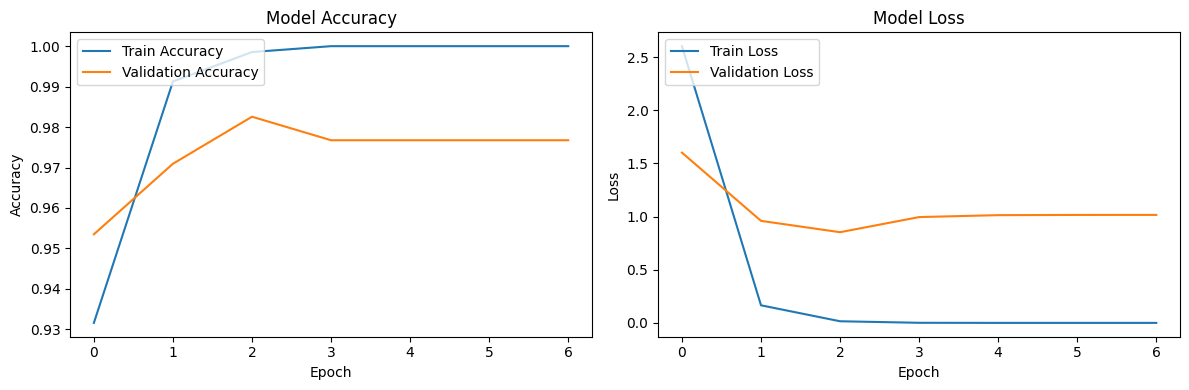

In [ ]:
def plot_learning_curves(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_learning_curves(history)

1/1 [==============================] - 1s 1s/step


<ipython-input-22-907053fae38f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  decoded_label = label_encoder.inverse_transform([int(prediction)])


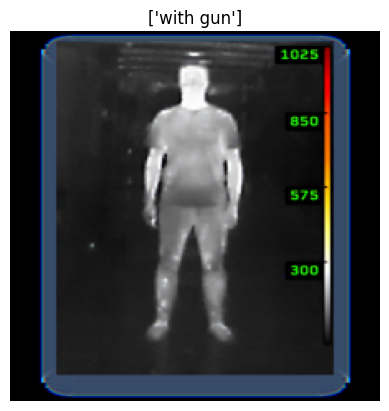

In [ ]:
from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.preprocessing import image
import requests
from io import BytesIO

def load_and_preprocess_image(img_url):
    # Download the image
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))

    # Convert image to RGB (if it has an alpha channel)
    if img.mode == 'RGBA':
        img = img.convert('RGB')

    # Resize image to 224x224 pixels
    img = img.resize((224, 224))

    # Convert image to array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the model's input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = preprocess_input(img_array)

    return img_array, img

# Load and preprocess the image
img_url = 'https://www.thermal.com/uploads/1/0/1/3/101388544/fp200-resolution-web-3_1.png'
img_array, img = load_and_preprocess_image(img_url)


# Make predictions
prediction = model.predict(img_array)
decoded_label = label_encoder.inverse_transform([int(prediction)])

# Display the image with the prediction label as title
plt.imshow(img)
plt.title(decoded_label)
plt.axis('off')
plt.show()
